In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoProcessor, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.gradient_rollout import AttentionGradRollout
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_image

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

In [3]:
device = 'cuda'

# Attention Rollout

## ImageNet

In [4]:
train_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=200, seed=1)

# test_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'test')

In [5]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [6]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [7]:
model = AutoModelForImageClassification.from_pretrained(
    "tzhao3/vit-tiny-imagenet", 
    attn_implementation = 'eager', 
    cache_dir = '/Data'
)\
    .to(device)
processor = AutoProcessor.from_pretrained("tzhao3/vit-tiny-imagenet")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [9]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [10]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


Removed 0.0 worst tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:14<00:00, 13.96it/s]


Removed 0.1 worst tokens. Accuracy = 0.9536082744598389


100%|██████████| 200/200 [00:14<00:00, 13.81it/s]


Removed 0.2 worst tokens. Accuracy = 0.9226804375648499


100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.907216489315033


100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Removed 0.4 worst tokens. Accuracy = 0.8814433217048645


100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Removed 0.5 worst tokens. Accuracy = 0.8556700944900513


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.7783505320549011


100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.6546391844749451


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Removed 0.8 worst tokens. Accuracy = 0.4793814420700073


100%|██████████| 200/200 [00:15<00:00, 12.72it/s]

Removed 0.9 worst tokens. Accuracy = 0.22164948284626007


In [11]:
pd.Series(accs)\
    .to_pickle("data/results/vit_attn_rollout_perturbation_negative.pkl")

## Gradient attention rollout

In [12]:
metric = AttentionGradRollout(model, attention_layer_name='attention.dropout')

In [13]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [14]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
            tokens['labels'] = torch.tensor(row['label'])
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 200/200 [00:12<00:00, 16.09it/s]


Removed 0.0 worst tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:12<00:00, 15.84it/s]


Removed 0.1 worst tokens. Accuracy = 0.9587628841400146


100%|██████████| 200/200 [00:12<00:00, 15.64it/s]


Removed 0.2 worst tokens. Accuracy = 0.938144326210022


100%|██████████| 200/200 [00:13<00:00, 15.34it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9432989954948425


100%|██████████| 200/200 [00:13<00:00, 15.18it/s]


Removed 0.4 worst tokens. Accuracy = 0.9226804375648499


100%|██████████| 200/200 [00:13<00:00, 14.87it/s]


Removed 0.5 worst tokens. Accuracy = 0.876288652420044


100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.8195876479148865


100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.7113401889801025


100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


Removed 0.8 worst tokens. Accuracy = 0.5103092789649963


100%|██████████| 200/200 [00:14<00:00, 14.13it/s]

Removed 0.9 worst tokens. Accuracy = 0.2525773048400879


In [15]:
pd.Series(accs)\
    .to_pickle("data/results/vit_grad_rollout_perturbation_negative.pkl")

## Influence 

In [16]:
metric = Influence(model, discard_ratio=0.9, is_vit=True, return_mask=False)

In [17]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [18]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue

        attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/200 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 200/200 [00:09<00:00, 20.87it/s]


Removed 0.0 worst tokens. Accuracy = 0.969072163105011


100%|██████████| 200/200 [00:09<00:00, 20.35it/s]


Removed 0.1 worst tokens. Accuracy = 0.9432989954948425


100%|██████████| 200/200 [00:09<00:00, 20.30it/s]


Removed 0.2 worst tokens. Accuracy = 0.9329897165298462


100%|██████████| 200/200 [00:10<00:00, 19.55it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9123711585998535


100%|██████████| 200/200 [00:10<00:00, 19.29it/s]


Removed 0.4 worst tokens. Accuracy = 0.907216489315033


100%|██████████| 200/200 [00:10<00:00, 18.92it/s]


Removed 0.5 worst tokens. Accuracy = 0.8608247637748718


100%|██████████| 200/200 [00:10<00:00, 18.57it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.8041236996650696


100%|██████████| 200/200 [00:10<00:00, 18.19it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.7061855792999268


100%|██████████| 200/200 [00:11<00:00, 17.89it/s]


Removed 0.8 worst tokens. Accuracy = 0.5257731676101685


100%|██████████| 200/200 [00:11<00:00, 17.54it/s]

Removed 0.9 worst tokens. Accuracy = 0.2164948433637619


In [19]:
pd.Series(accs)\
    .to_pickle("data/results/vit_influence_perturbation_negative.pkl")

## Final plot

attn_rollout - AUC = 0.7028350599110127
influence - AUC = 0.7185567073523998
grad_rollout - AUC = 0.7291237145662308


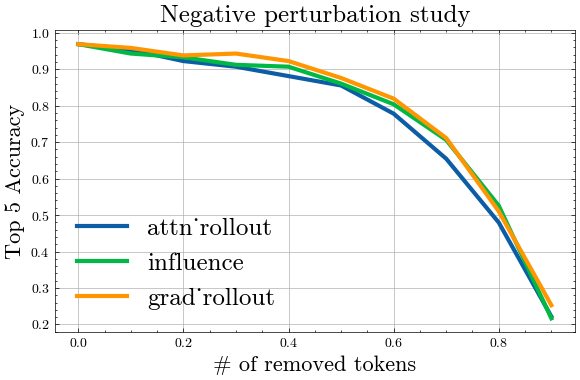

In [21]:
metrics = ['attn_rollout','influence', 'grad_rollout']

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/vit_{metric}_perturbation_negative.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")
    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Negative perturbation study", fontsize = 18)
plt.ylabel("Top 5 Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()